In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import scipy.stats as stats
import seaborn as sns
from yahooquery import Ticker
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datapackage
from datetime import date,datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn")
import datetime


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/2314218888.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Jupyter notebook where we create some basic auto-analysis financial tool.
### Let's start with sector differences


In [2]:
data_url = 'https://datahub.io/core/s-and-p-500-companies/datapackage.json'
package = datapackage.Package(data_url)
resources = package.resources
for resource in resources:
    if resource.tabular:
        stock_to_analyze = pd.read_csv(resource.descriptor['path'])

stock_to_analyze


,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


In [3]:
def compute_month_return(stock): 
    month_return=stock_data[stock].Close[-1] / stock_data[stock].Close[0]
    return month_return
def compute_std_deviation(stock):
    stock_data[stock]['log_return'] = np.log(stock_data[stock].Close.div(stock_data[stock].Close.shift(1)))
    std = stock_data[stock]['log_return'].std()
    return std

### Let's take the last year 

In [4]:
end = date.today()
start = "2022-01-01"

### Large dataset, all of s&p 500 stocks


### Small dataset


In [5]:
symbol=['AAPL','MSFT','TSLA','CTLT','ALGN','FTNT','CINF','GWW','ANET','AXP','RCL','URI','FOXA','HSY','UDR','FOX','CLX','ESS','NUE','MOS','NRG','NI','BKR','WMB']
stock_data={}
for stock in symbol:
    stock_data[stock]= yf.download(stock,start,end, auto_adjust=True,ignore_tz=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Analysis of the returns, mean and std which tells us information about volatility and reward. Can be summarized in sharp ration
### analisi dei ricavi, come media e deviazione standard, ci danno informazioni circa la volatilita e il ricavo medio. Può essere semplificato nello sharpe ratio


In [6]:
stocks_general_properties={}
for stock in symbol:
    dictionary={}
    stock_data[stock]['historic_growth'] = stock_data[stock].Close.div(stock_data[stock].Close.loc[stock_data[stock].Close.first_valid_index()]).mul(100)
    stock_data[stock]['log_return'] = np.log(stock_data[stock].Close.div(stock_data[stock].Close.shift(1)))
    weeks = [g for n, g in stock_data[stock].groupby(pd.Grouper(freq='W'))]
    for week in weeks:
        week_return=week.Close[-1] / week.Close[0]
        std = week['log_return'].std()
        volume_change=week.Volume[-1]/week.Volume[0]
        dictionary[week.iloc[:1].index.item()]=[stock,std,week_return,volume_change]
    stocks_general_properties[stock]=pd.DataFrame.from_dict(dictionary, orient='index',columns=['stock','std','week_return','volume_change'])
    stocks_general_properties[stock] = stocks_general_properties[stock].rename(columns = {'index':'month_year'})
    stocks_general_properties[stock]['week_return_future'] =stocks_general_properties[stock]['week_return'].shift(-1)
    
    stocks_general_properties[stock]['week_return_old'] =stocks_general_properties[stock]['week_return'].shift(1)
    stocks_general_properties[stock]['std_old'] =stocks_general_properties[stock]['std'].shift(1)
    stocks_general_properties[stock]['volume_change_old'] =stocks_general_properties[stock]['volume_change'].shift(1)
    
    stocks_general_properties[stock]['week_return_older'] =stocks_general_properties[stock]['week_return'].shift(2)
    stocks_general_properties[stock]['std_older'] =stocks_general_properties[stock]['std'].shift(2)
    stocks_general_properties[stock]['volume_change_older'] =stocks_general_properties[stock]['volume_change'].shift(2)

    stocks_general_properties[stock]['week_return_oldest'] =stocks_general_properties[stock]['week_return'].shift(3)
    stocks_general_properties[stock]['std_oldest'] =stocks_general_properties[stock]['std'].shift(3)
    stocks_general_properties[stock]['volume_change_oldest'] =stocks_general_properties[stock]['volume_change'].shift(3)

    
    stocks_general_properties[stock]['position']=stocks_general_properties[stock]['week_return_future'].apply(lambda x: 1 if x>1 else 0)
stocks_general_properties['TSLA']

,stock,std,week_return,volume_change,week_return_future,week_return_old,std_old,volume_change_old,week_return_older,std_older,volume_change_older,week_return_oldest,std_oldest,volume_change_oldest,position
2022-01-03,TSLA,0.0138,0.8560,0.8098,0.9920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-01-10,TSLA,0.0433,0.9920,0.7943,0.9160,0.8560,0.0138,0.8098,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-01-18,TSLA,0.0232,0.9160,1.5495,0.9101,0.9920,0.0433,0.7943,0.8560,0.0138,0.8098,NaN,NaN,NaN,0
2022-01-24,TSLA,0.0590,0.9101,0.8893,0.9857,0.9160,0.0232,1.5495,0.9920,0.0433,0.7943,0.8560,0.0138,0.8098,0
2022-01-31,TSLA,0.0527,0.9857,0.7050,0.9478,0.9101,0.0590,0.8893,0.9160,0.0232,1.5495,0.9920,0.0433,0.7943,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,TSLA,0.0336,1.0109,1.0997,1.0702,1.1399,0.0460,1.0077,1.2376,0.0518,1.5094,1.0147,0.0453,0.7446,1
2023-02-13,TSLA,0.0491,1.0702,1.2392,0.9975,1.0109,0.0336,1.0997,1.1399,0.0460,1.0077,1.2376,0.0518,1.5094,0
2023-02-21,TSLA,0.0323,0.9975,0.7901,0.9526,1.0702,0.0491,1.2392,1.0109,0.0336,1.0997,1.1399,0.0460,1.0077,0
2023-02-27,TSLA,0.0448,0.9526,0.9551,0.8949,0.9975,0.0323,0.7901,1.0702,0.0491,1.2392,1.0109,0.0336,1.0997,0


In [7]:
stocks_global=pd.DataFrame()
for stock in symbol:
    stocks_global=pd.concat([stocks_global,stocks_general_properties[stock]])
stocks_global


,stock,std,week_return,volume_change,week_return_future,week_return_old,std_old,volume_change_old,week_return_older,std_older,volume_change_older,week_return_oldest,std_oldest,volume_change_oldest,position
2022-01-03,AAPL,0.0116,0.9459,0.8298,1.0051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2022-01-10,AAPL,0.0130,1.0051,0.7534,0.9565,0.9459,0.0116,0.8298,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-01-18,AAPL,0.0051,0.9565,1.3506,1.0539,1.0051,0.0130,0.7534,0.9459,0.0116,0.8298,NaN,NaN,NaN,1
2022-01-24,AAPL,0.0326,1.0539,1.1087,0.9876,0.9565,0.0051,1.3506,1.0051,0.0130,0.7534,0.9459,0.0116,0.8298,0
2022-01-31,AAPL,0.0155,0.9876,0.7137,0.9824,1.0539,0.0326,1.1087,0.9565,0.0051,1.3506,1.0051,0.0130,0.7534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-06,WMB,0.0148,1.0038,1.1556,0.9827,1.0338,0.0219,1.1991,0.9946,0.0054,0.7295,0.9597,0.0183,1.3239,0
2023-02-13,WMB,0.0129,0.9827,2.4908,1.0127,1.0038,0.0148,1.1556,1.0338,0.0219,1.1991,0.9946,0.0054,0.7295,1
2023-02-21,WMB,0.0097,1.0127,0.5695,1.0088,0.9827,0.0129,2.4908,1.0038,0.0148,1.1556,1.0338,0.0219,1.1991,1
2023-02-27,WMB,0.0175,1.0088,0.7334,0.9557,1.0127,0.0097,0.5695,0.9827,0.0129,2.4908,1.0038,0.0148,1.1556,0


stocks_general_properties['AAPL']

In [8]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    MLPClassifier(alpha=1, max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

Nearest Neighbors
0.5065217391304347


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


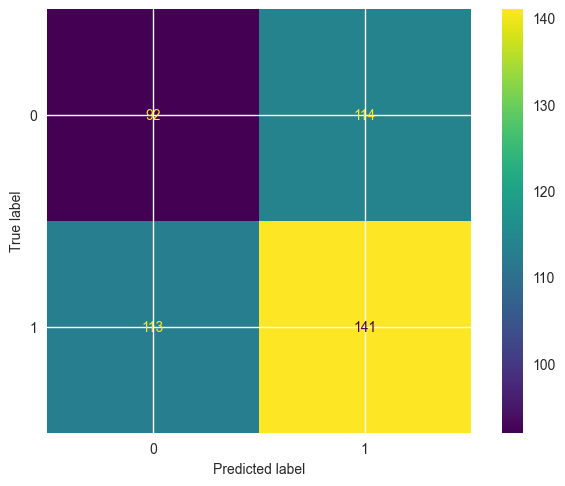

/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


Linear SVM
0.5521739130434783


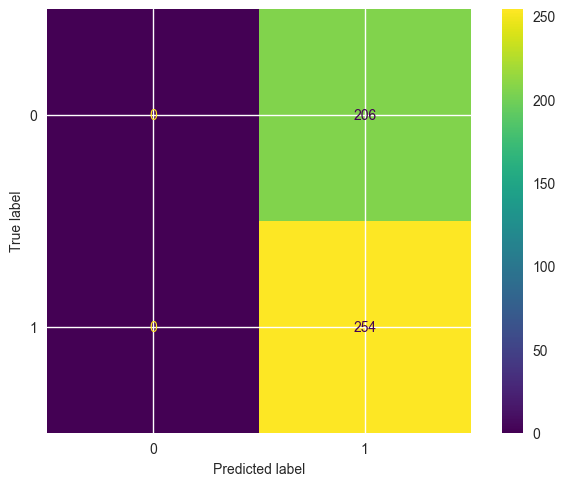

RBF SVM
0.5195652173913043


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


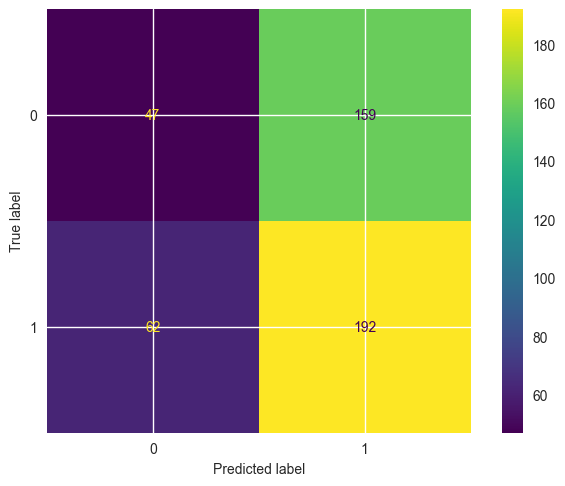

Gaussian Process
0.5282608695652173


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


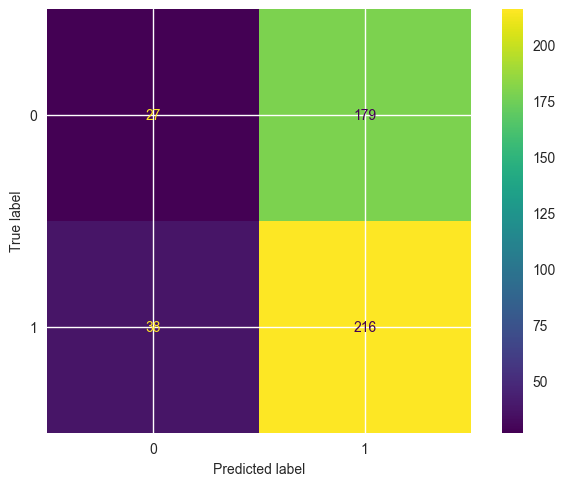

Decision Tree
0.5347826086956522


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


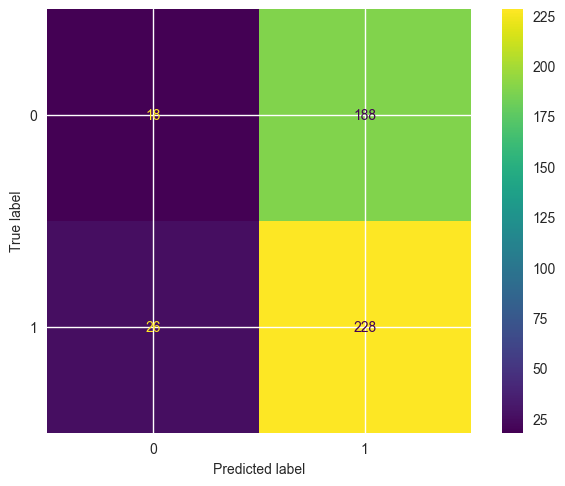

/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


Random Forest
0.5217391304347826


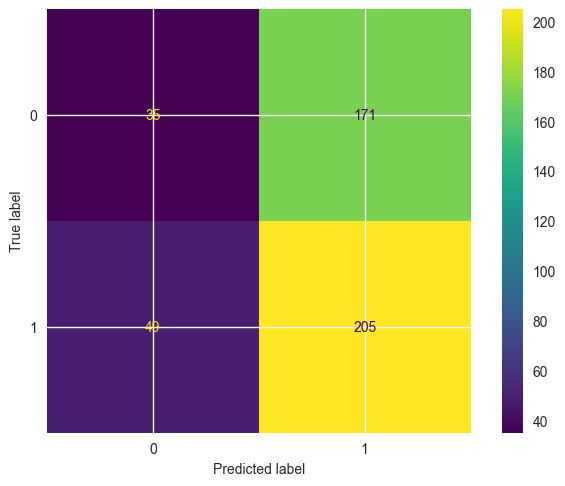

/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


Neural Net
0.5304347826086957


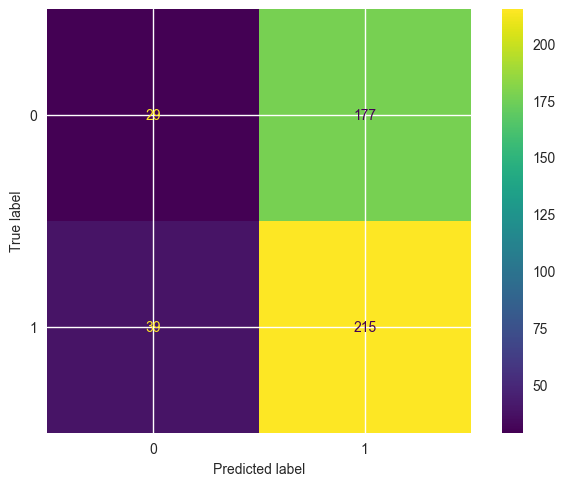

/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


AdaBoost
0.49782608695652175


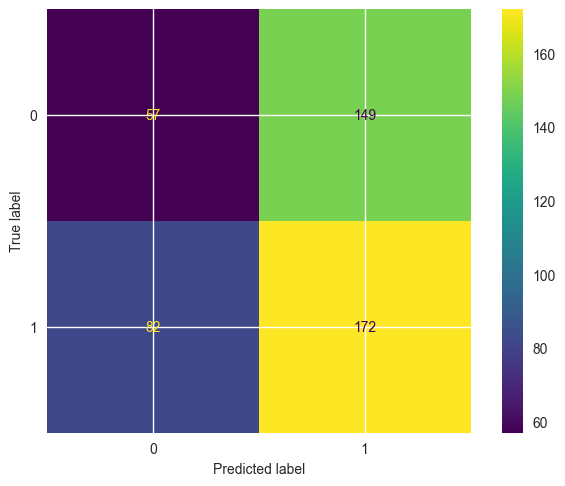

/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


Naive Bayes
0.5304347826086957


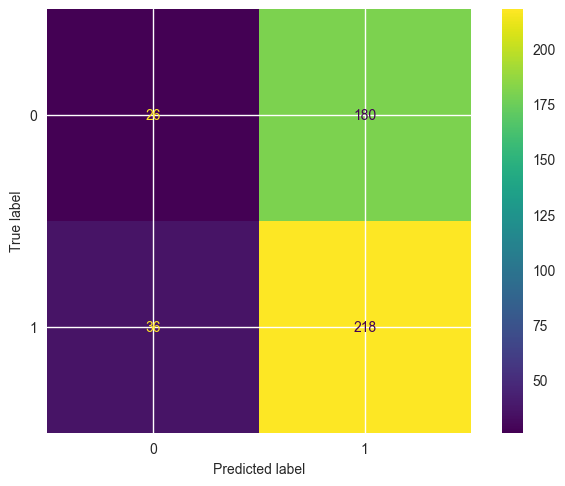

QDA
0.5456521739130434


/var/folders/bc/qtnxfm1141qg_dqv2dlcr5880000gn/T/ipykernel_51515/3376683303.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])


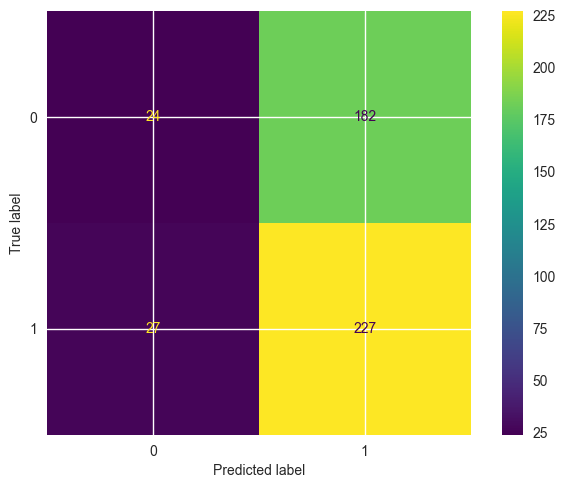

In [9]:
stocks_global=stocks_global.dropna()
x_cols = ['std', 'week_return','volume_change']
X = stocks_global.loc[:, x_cols]
y = stocks_global.position
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        stocks_global[name]=clf.predict(stocks_global.loc[:, x_cols])
        print(name)
        print(score)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        

In [36]:
y = stocks_global.week_return_future
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train,y_train)
regr.score(X_test, y_test)
r2 = mean_squared_error(y_test, regr.predict(X_test))
print(r2)

0.0026972504924602254


In [ ]:
col_list= ['Nearest Neighbors', 'Linear SVM', 'RBF SVM','Gaussian Process','Decision Tree','Random Forest','Neural Net','AdaBoost','Naive Bayes','QDA']
stocks_global['Sum'] = stocks_global[col_list].sum(axis=1)
stocks_global.groupby('stock')
stocks_global.to_csv("stock_global.csv")
stock_computed={}
gb = stocks_global.groupby('stock')    
for x in gb.groups:
    stock_computed[x]=gb.get_group(x)

for stock in symbol:
    #print(stock_computed[stock]['Sum'].value_counts())
    #display(stock_computed[stock][stock_computed[stock]['Sum']==10])
    print("stock:", end = ' '),
    print(stock)
    print("global return from 1st of January: ", end = ' '),
    print(round(stock_computed[stock]['week_return_future'][stock_computed[stock]['Sum']==10].prod(),2))
    print("--")
    print("")
    
    
stock_computed["AAPL"][stock_computed["AAPL"]['Sum']==10].to_csv("Apple.csv")




In [ ]:
stock_buy={}
for stock in symbol:
    stock_computed[stock]['computed_postion']=stock_computed[stock]['Sum'].apply(lambda row: 1 if row == 10 else 0)
    stock_buy[stock]=stock_computed[stock][stock_computed[stock].computed_postion==1]
    stock_buy[stock].drop(['std','volume_change','week_return_old','std_old','volume_change_old','week_return_older','std_older','volume_change_oldest','std_oldest','week_return_oldest','volume_change_older','week_return','position','Nearest Neighbors','Linear SVM','RBF SVM','Gaussian Process','Decision Tree','Random Forest','Neural Net','AdaBoost','Naive Bayes','QDA','Sum','computed_postion'], inplace=True, axis=1)
    display(stock_buy[stock])

    
    
    

In [ ]:
strategy=pd.DataFrame()

for stock in symbol:
    df1=stock_buy["AAPL"].drop('stock',axis=1)
    strategy = pd.concat((strategy, stock_buy[stock]['week_return_future']), axis=1)
strategy=strategy.sort_index()

cols = []
count = 1
for column in strategy.columns:
    if column == 'week_return_future':
        cols.append(f'week_return_future_{count}')
        count+=1
        continue
    cols.append(column)
strategy.columns = cols

strategy['mean']=strategy.mean(axis=1)
strategy=strategy[['mean']].copy()
display(strategy)
print(strategy.prod())


In [ ]:
end = date.today()
start = "2018-01-01"
symbol=['AAPL','MSFT','TSLA','CTLT','ALGN','FTNT','CINF','GWW','ANET','AXP','RCL','URI','FOXA','HSY','UDR','FOX','CLX','ESS','NUE','MOS','NRG','NI','BKR','WMB']
stock_data={}
for stock in symbol:
    stock_data[stock]= yf.download(stock,start,end, auto_adjust=True,ignore_tz=True)
stocks_general_properties={}
for stock in symbol:
    dictionary={}
    stock_data[stock]['historic_growth'] = stock_data[stock].Close.div(stock_data[stock].Close.loc[stock_data[stock].Close.first_valid_index()]).mul(100)
    stock_data[stock]['log_return'] = np.log(stock_data[stock].Close.div(stock_data[stock].Close.shift(1)))
    weeks = [g for n, g in stock_data[stock].groupby(pd.Grouper(freq='W'))]
    for week in weeks:
        week_return=week.Close[-1] / week.Close[0]
        std = week['log_return'].std()
        volume_change=week.Volume[-1]/week.Volume[0]
        dictionary[week.iloc[:1].index.item()]=[stock,std,week_return,volume_change]
    stocks_general_properties[stock]=pd.DataFrame.from_dict(dictionary, orient='index',columns=['stock','std','week_return','volume_change'])
    stocks_general_properties[stock] = stocks_general_properties[stock].rename(columns = {'index':'month_year'})
    stocks_general_properties[stock]['week_return_future'] =stocks_general_properties[stock]['week_return'].shift(-1)
    
    stocks_general_properties[stock]['week_return_old'] =stocks_general_properties[stock]['week_return'].shift(1)
    stocks_general_properties[stock]['std_old'] =stocks_general_properties[stock]['std'].shift(1)
    stocks_general_properties[stock]['volume_change_old'] =stocks_general_properties[stock]['volume_change'].shift(1)
    
    stocks_general_properties[stock]['week_return_older'] =stocks_general_properties[stock]['week_return'].shift(2)
    stocks_general_properties[stock]['std_older'] =stocks_general_properties[stock]['std'].shift(2)
    stocks_general_properties[stock]['volume_change_older'] =stocks_general_properties[stock]['volume_change'].shift(2)

    stocks_general_properties[stock]['week_return_oldest'] =stocks_general_properties[stock]['week_return'].shift(3)
    stocks_general_properties[stock]['std_oldest'] =stocks_general_properties[stock]['std'].shift(3)
    stocks_general_properties[stock]['volume_change_oldest'] =stocks_general_properties[stock]['volume_change'].shift(3)

    
    stocks_general_properties[stock]['position']=stocks_general_properties[stock]['week_return_future'].apply(lambda x: 1 if x>1 else 0)
stocks_general_properties['TSLA']
stocks_global=pd.DataFrame()
for stock in symbol:
    stocks_global=pd.concat([stocks_global,stocks_general_properties[stock]])
stocks_global
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    MLPClassifier(alpha=1, max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]




In [ ]:
multiplier=1
strategy=pd.DataFrame(columns=['multiplier'])
for x in range(60):
    
    start=datetime.datetime(2020,1,3)+timedelta(weeks=x)
    end = start + timedelta(weeks=104)
    start=start.strftime('%Y-%m-%d')
    end=end.strftime('%Y-%m-%d')
    #print(start)
    print(end)
    stock_in_loop=stocks_global.loc[stocks_global.index>start]
    stock_in_loop=stock_in_loop.loc[stock_in_loop.index<end]
    stock_in_loop=stock_in_loop.dropna()
    #display(stock_in_loop)
    x_cols = ['std', 'week_return','volume_change','std_old','week_return_old','volume_change_old','std_older','week_return_older','volume_change_older','std_oldest','week_return_oldest','volume_change_oldest']
    X = stock_in_loop.loc[:, x_cols]
    y = stock_in_loop.position
    y_regressor=stock_in_loop.week_return_future
    result={}
    regr = RandomForestRegressor(max_depth=20, random_state=0)
    regr.fit(X, y_regressor)
    for stock in symbol:
        result[stock]=pd.DataFrame(columns=names)
            
    for name, clf in zip(names, classifiers):
            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X, y)
            y_pred = clf.predict(X)
            for stock in symbol: 
                X_to_pred=stocks_general_properties[stock].loc[stocks_general_properties[stock].index>end].head(1).loc[:, x_cols]
                y_pred = clf.predict(X_to_pred).item()
                result[stock].at[1,name]=y_pred
                
    
    counter=0
    return_total=0
    for stock in symbol:
        sum_position=int(result[stock][names].sum(axis=1).item())
        if sum_position == 10:
            position=1
            counter=counter+1
            return_total=return_total+stocks_general_properties[stock].loc[stocks_general_properties[stock].index>end].head(1).week_return_future.item()
        else:
            position = 0
    if counter != 0:
        multiplier=multiplier*return_total/counter
    strategy.at[end,'multiplier']=multiplier
    print(multiplier)
    display(strategy)

In [ ]:
import sys
!{sys.executable} -m pip install datapackage